In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, TreeSearch, BDeuScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.independencies import IndependenceAssertion


df = pd.read_csv("CVD_cleaned.csv")
print(f'dfset contains {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

dfset contains 308854 rows and 19 columns


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


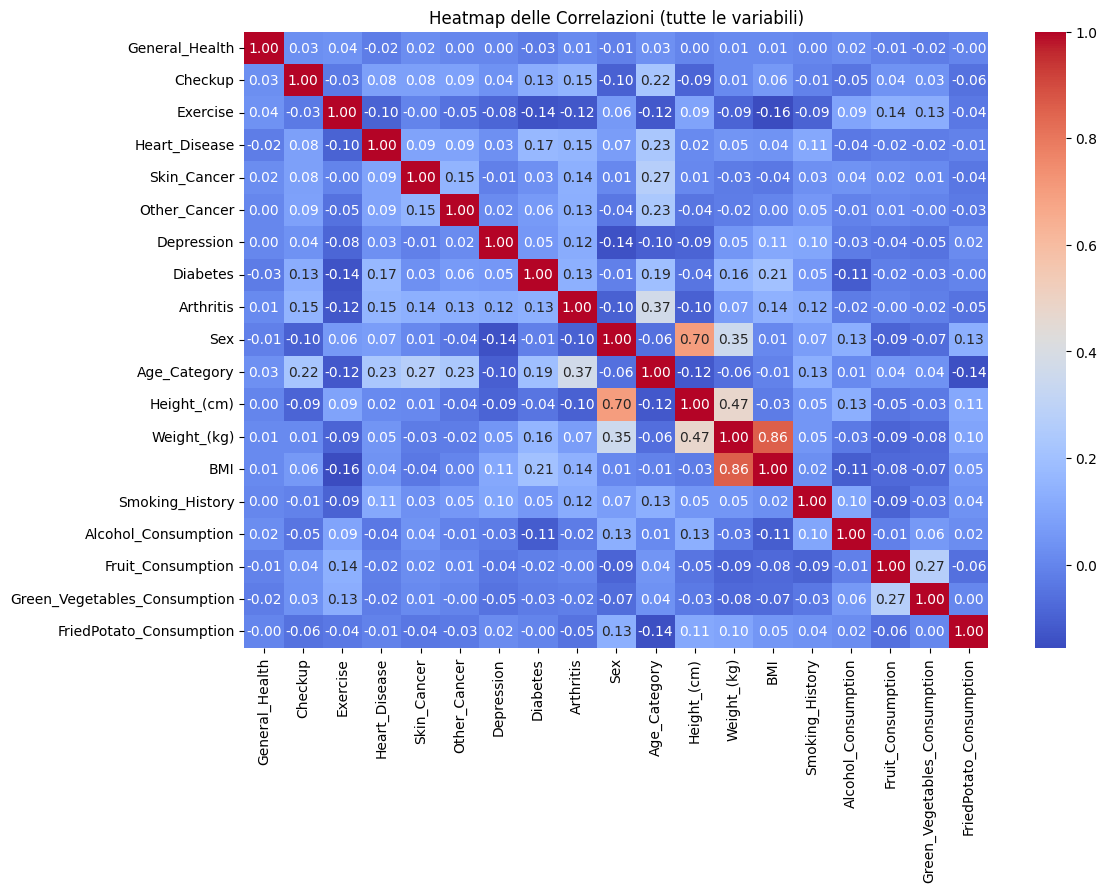

In [4]:
# Crea un dataframe temporaneo
df_temp = df.copy()

# Converte le variabili non numeriche in numeriche utilizzando il label encoding
for col in df_temp.select_dtypes(include=['object']).columns:
    df_temp[col] = df_temp[col].astype('category').cat.codes

# Calcola e visualizza la matrice di correlazione
plt.figure(figsize=(12, 8))
sns.heatmap(df_temp.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap delle Correlazioni (tutte le variabili)")
plt.show()

In [5]:
# Rimuovi le colonne 'General_Health' e 'Checkup'
df.drop(columns=['General_Health', 'Checkup'], inplace=True)

# Crea una nuova variabile 'Cancer'
df['Cancer'] = df.apply(lambda row: 'Yes' if row['Skin_Cancer'] == 'Yes' or row['Other_Cancer'] == 'Yes' else 'No', axis=1)

# Rimuovi le colonne 'Skin_Cancer' e 'Other_Cancer'
df.drop(columns=['Skin_Cancer', 'Other_Cancer'], inplace=True)

print(len(df.columns))
df.columns

16


Index(['Exercise', 'Heart_Disease', 'Depression', 'Diabetes', 'Arthritis',
       'Sex', 'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI',
       'Smoking_History', 'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption', 'Cancer'],
      dtype='object')

In [21]:
# cols_to_discretize = [
#     'Height_(cm)',
#     'Weight_(kg)',
#     'BMI',
#     'Alcohol_Consumption',
#     'Fruit_Consumption',
#     'Green_Vegetables_Consumption',
#     'FriedPotato_Consumption',
# ]

# for col in cols_to_discretize:
#     plt.figure(figsize=(12, 6))
#     ax = sns.countplot(x=df[col])
#     ticks = ax.get_xticks()
#     ax.set_xticks(ticks[::40])
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(col)
#     plt.ylabel('Count')
#     plt.show()

In [7]:
from sklearn.preprocessing import KBinsDiscretizer
colonne = ['Height_(cm)', 'Weight_(kg)', 'BMI']

# Inizializza il discretizzatore
discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')

# Applica la discretizzazione
df_disc = df.copy()
df_disc[colonne] = discretizer.fit_transform(df[colonne])



# Discretize 'Alcohol_Consumption'


# Discretize 'Fruit_Consumption'

# Discretize 'Green_Vegetables_Consumption'

# Discretize 'FriedPotato_Consumption'



In [19]:
# for col in colonne:
#     plt.figure(figsize=(12, 6))
#     ax = sns.countplot(x=df_disc[col])
#     ticks = ax.get_xticks()
#     # ax.set_xticks(ticks[::40])
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(col)
#     plt.ylabel('Count')
#     plt.show()

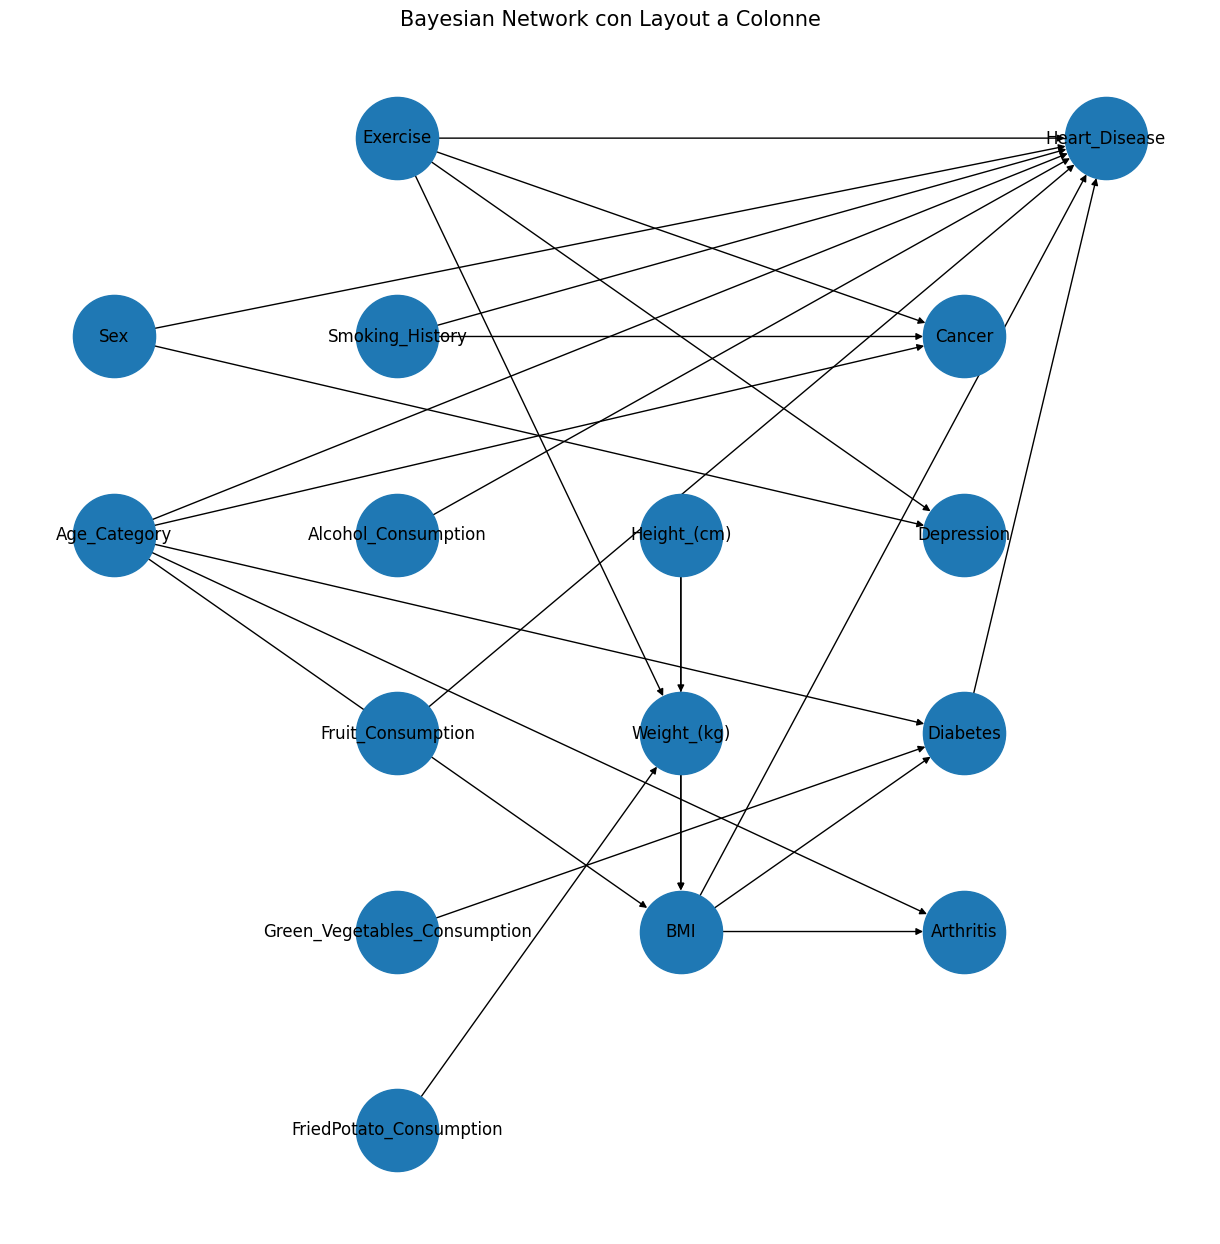

In [16]:
custom_model = BayesianModel([
    ('Height_(cm)', 'Weight_(kg)'),
    ('Height_(cm)', 'BMI'),
    ('Weight_(kg)', 'BMI'),

    ('Sex', 'Heart_Disease'),
    ('Sex', 'Depression'),
    ('Age_Category', 'Heart_Disease'),
    ('Age_Category', 'Diabetes'),
    ('Age_Category', 'Arthritis'),
    ('Age_Category', 'BMI'),
    ('Age_Category', 'Cancer'),

    ('Smoking_History', 'Heart_Disease'),
    ('Smoking_History', 'Cancer'),

    ('Alcohol_Consumption', 'Heart_Disease'),
    ('Fruit_Consumption', 'Heart_Disease'),
    ('Green_Vegetables_Consumption', 'Diabetes'),
    ('FriedPotato_Consumption', 'Weight_(kg)'),
    ('Exercise', 'Heart_Disease'),
    ('Exercise', 'Depression'),
    ('Exercise', 'Weight_(kg)'),
    ('Exercise', 'Cancer'),

    ('BMI', 'Heart_Disease'),
    ('BMI', 'Diabetes'),
    ('BMI', 'Arthritis'),

    ('Diabetes', 'Heart_Disease'),
])



pos = {
    # Colonna 1: Fattori di base
    'Sex': (0, 3),
    'Age_Category': (0, 2),

    # Colonna 2: Stile di vita e dieta
    'Exercise': (2, 4),
    'Smoking_History': (2, 3),
    'Alcohol_Consumption': (2, 2),
    'Fruit_Consumption': (2, 1),
    'Green_Vegetables_Consumption': (2, 0),
    'FriedPotato_Consumption': (2, -1),

    # Colonna 3: Misure fisiche
    'Height_(cm)': (4, 2),
    'Weight_(kg)': (4, 1),
    'BMI': (4, 0),

    # Colonna 4: Condizioni mediche
    'Heart_Disease': (7, 4),
    'Cancer': (6, 3),
    'Depression': (6, 2),
    'Diabetes': (6, 1),
    'Arthritis': (6, 0),
}

# Disegno del grafo
plt.figure(figsize=(12, 12))
G = nx.DiGraph(custom_model.edges())
nx.draw(G, pos, with_labels=True, node_size=3500)

plt.title("Bayesian Network con Layout a Colonne", fontsize=15)
plt.axis("off")
plt.show()


Building tree:   0%|          | 0/120.0 [00:00<?, ?it/s]

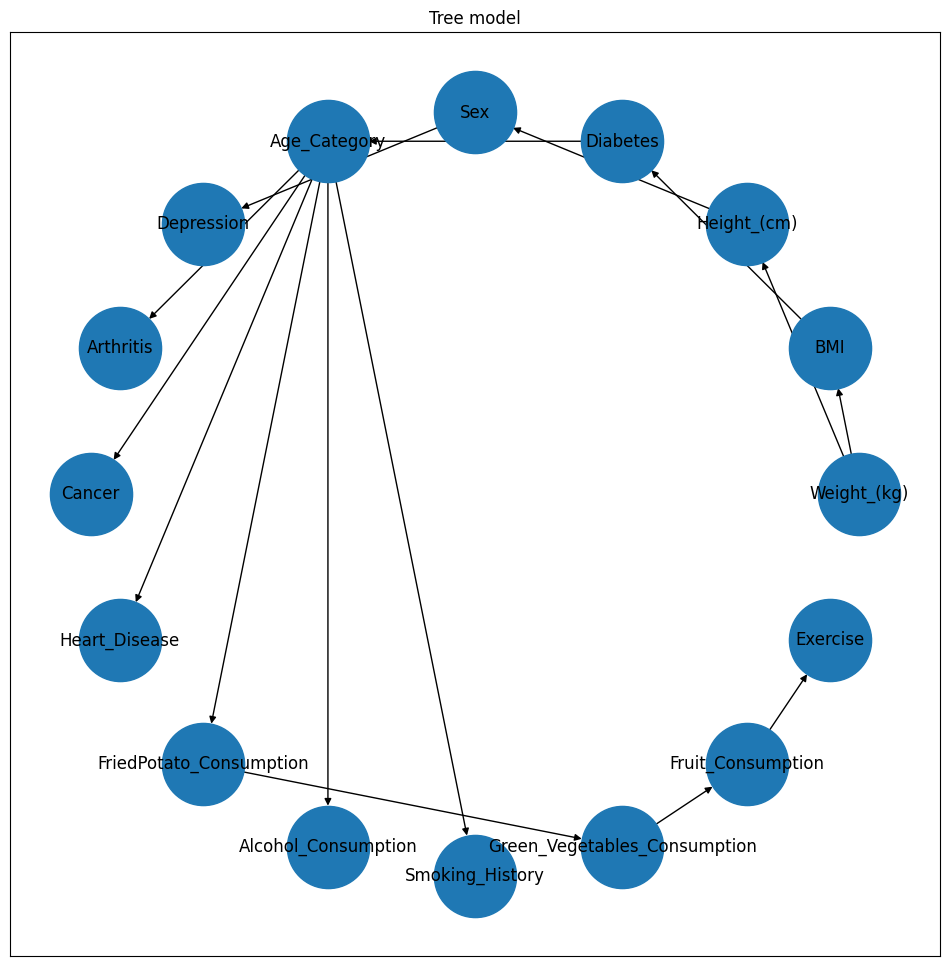

In [10]:
# ts = TreeSearch(data=df_disc, root_node='State')
ts = TreeSearch(data=df_disc)
tree_model = ts.estimate()

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.circular_layout(tree_model), ax=ax, node_size=3500)
# fig.savefig('tree')
ax.set_title('Tree model')
tree_model = BayesianModel(tree_model.edges())

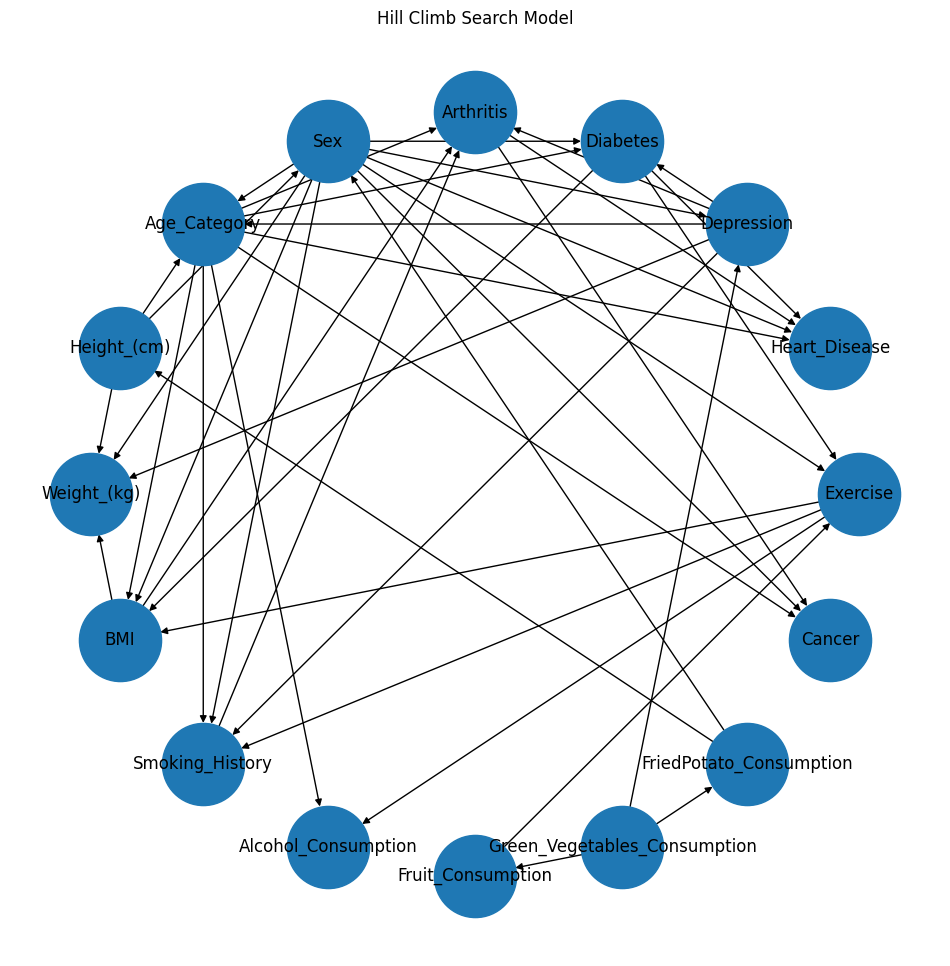

In [11]:
scorer = BDeuScore(data=df_disc)

hc = HillClimbSearch(data=df_disc)

hc_model = hc.estimate(scoring_method=scorer, show_progress=False)

plt.figure(figsize=(12, 12))
pos_hc = nx.drawing.layout.circular_layout(hc_model)
nx.draw_networkx(hc_model, pos=pos_hc, node_size=3500, with_labels=True, arrows=True)
plt.title('Hill Climb Search Model')
plt.axis('off')
plt.show()

hc_model_bayes = BayesianModel(hc_model.edges())

In [12]:
models = [('custom', custom_model), ('tree', tree_model), ('hc', hc_model_bayes)]
for name, model in models:
    print(f'Computing CPDs for {name} model')
    model.fit(df_disc, estimator=MaximumLikelihoodEstimator)

Computing CPDs for custom model
Computing CPDs for tree model
Computing CPDs for hc model


# Questions

In [13]:
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt

# Create inference objects for both models
infer_custom = VariableElimination(custom_model)
infer_tree = VariableElimination(tree_model)
infer_hc = VariableElimination(hc_model_bayes)


## Query 1:
"What's the probability of developing a cardiac disease given that the patient is non smoker and athletic?"

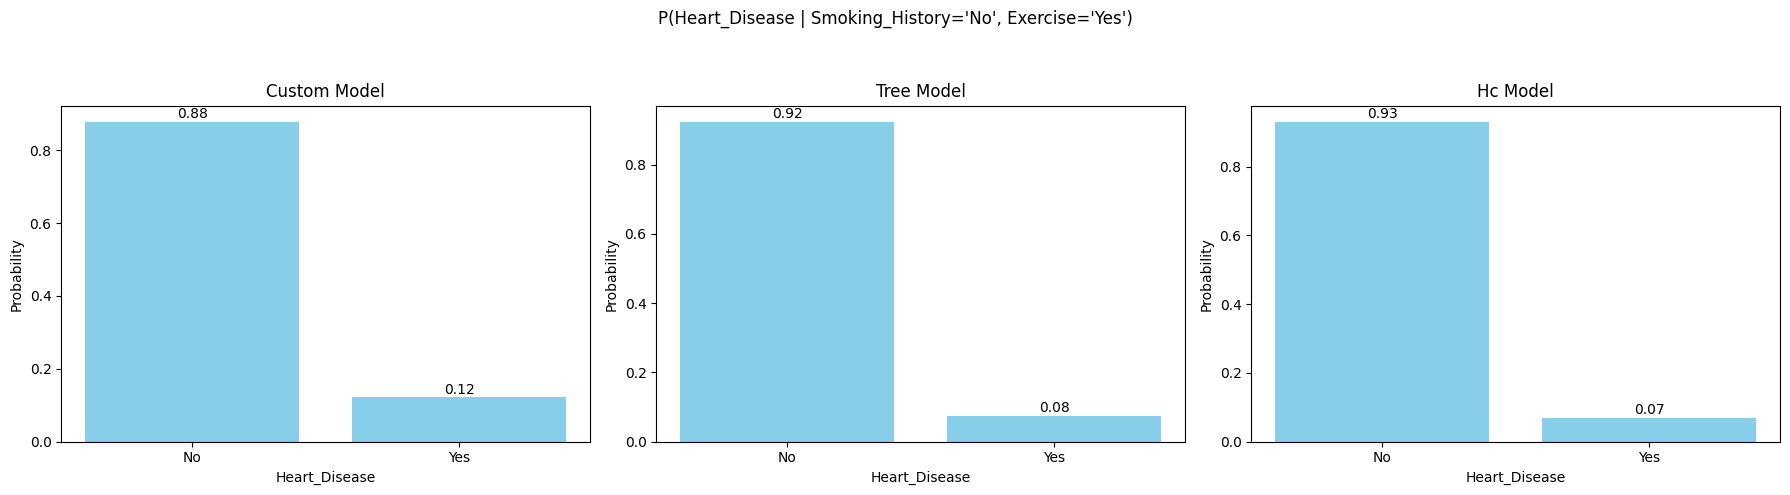

In [14]:
# Query the probability of Heart_Disease given Smoking_History is 'No' (non smoker)
# and Exercise is 'Yes' (athletic) for all three models,
# and plot the result as bar charts.

evidence = {'Smoking_History': 'No', 'Exercise': 'Yes'}

# Perform inference queries
result_custom = infer_custom.query(variables=['Heart_Disease'], evidence=evidence)
result_tree   = infer_tree.query(variables=['Heart_Disease'], evidence=evidence)
result_hc     = infer_hc.query(variables=['Heart_Disease'], evidence=evidence)

# Create a dictionary to loop over the results
results = {
    'custom': result_custom,
    'tree': result_tree,
    'hc': result_hc
}

# Plot the probability distributions
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, result) in zip(axes, results.items()):
    # Try to get state names; fallback to hard-coded if not available.
    try:
        states = result.state_names['Heart_Disease']
    except (AttributeError, KeyError):
        states = ['No', 'Yes']
    probs = result.values

    ax.bar(states, probs, color='skyblue')
    ax.set_title(f"{name.capitalize()} Model")
    ax.set_xlabel("Heart_Disease")
    ax.set_ylabel("Probability")
    for i, v in enumerate(probs):
        ax.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)
        
plt.suptitle("P(Heart_Disease | Smoking_History='No', Exercise='Yes')")
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

## Query 2:
"What is the combined effect of factors such as alcohol consumption, diet (fruit, vegetables, and fried potatoes) and physical activity on the probability of developing cancer?"

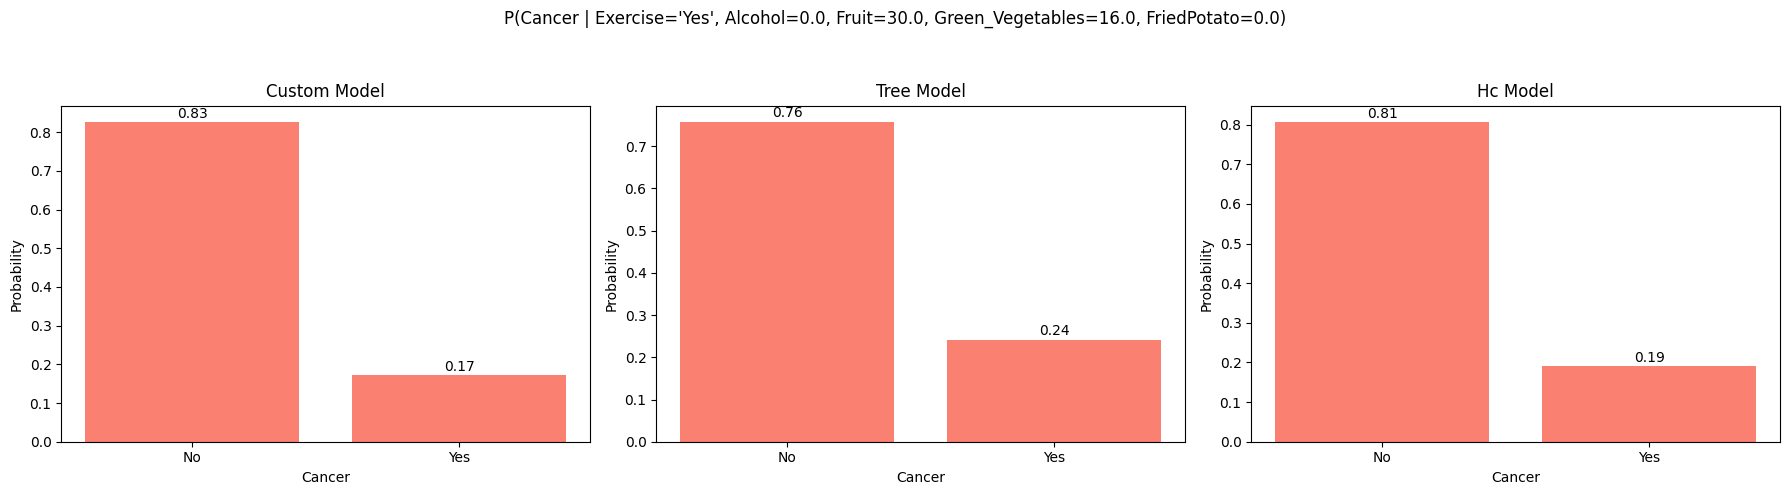

In [17]:
# In questa cella analizziamo l'effetto combinato dei fattori:
# consumo di alcol, dieta (frutta, verdure e patate fritte) e attività fisica
# sulla probabilità di sviluppare il cancro.
#
# Assumiamo uno scenario "salutare" con:
# • Esercizio fisico: Yes
# • Consumo di alcol: 0.0
# • Consumo di frutta: 30.0
# • Consumo di verdure verdi: 16.0
# • Consumo di patate fritte: 0.0

evidence_cancer = {
    'Exercise': 'Yes',
    'Alcohol_Consumption': 0.0,
    'Fruit_Consumption': 30.0,
    'Green_Vegetables_Consumption': 16.0,
    'FriedPotato_Consumption': 0.0
}

# Eseguiamo l'inferenza per il modello personalizzato, l'albero e il modello ottenuto tramite Hill Climb.
result_custom_cancer = infer_custom.query(variables=['Cancer'], evidence=evidence_cancer)
result_tree_cancer   = infer_tree.query(variables=['Cancer'], evidence=evidence_cancer)
result_hc_cancer     = infer_hc.query(variables=['Cancer'], evidence=evidence_cancer)

results_cancer = {
    'custom': result_custom_cancer,
    'tree': result_tree_cancer,
    'hc': result_hc_cancer
}

# Plottiamo le distribuzioni di probabilità per il cancro per ogni modello.
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, result) in zip(axes, results_cancer.items()):
    try:
        states = result.state_names['Cancer']
    except (AttributeError, KeyError):
        states = ['No', 'Yes']
    probs = result.values
    ax.bar(states, probs, color='salmon')
    ax.set_title(f"{name.capitalize()} Model")
    ax.set_xlabel("Cancer")
    ax.set_ylabel("Probability")
    for i, p in enumerate(probs):
        ax.text(i, p + 0.01, f"{p:.2f}", ha='center', fontsize=10)

plt.suptitle("P(Cancer | Exercise='Yes', Alcohol=0.0, Fruit=30.0, Green_Vegetables=16.0, FriedPotato=0.0)")
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

Ecco alcune query interessanti per un modello bayesiano che sfrutta le colonne del dataset:

Influenza dell'esercizio e della storia del fumo sulla salute cardiaca:

Qual è la probabilità di sviluppare malattie cardiache dato un alto livello di esercizio fisico e una storia negativa di fumo?

Relazione tra dieta e rischio di diabete:

In che modo il consumo di frutta, verdure (in particolare quelle verdi) e patate fritte influenza la probabilità di sviluppare il diabete?

Interazione tra BMI, età e malattie croniche:

Dato il BMI, l'altezza, il peso e la categoria d'età, qual è la probabilità condizionata di avere il diabete o altre malattie croniche come l'artrite?

Effetto combinato degli stili di vita sul cancro:

Qual è l'effetto combinato di fattori quali consumo di alcol, dieta (frutta, verdure e patate fritte) e attività fisica sulla probabilità di sviluppare il cancro?

Relazione tra depressione e fattori demografici:

Come influiscono sesso, categoria d'età e stile di vita (esercizio fisico, storia di fumo e consumo di alcol) sulla probabilità di sviluppare la depressione?

Interazioni multiple per la salute complessiva:

Qual è la probabilità che un individuo presenti più condizioni (ad esempio, malattie cardiache, diabete e artrite) in base a un insieme di fattori come BMI, dieta, attività fisica e storia di fumo?

Confronto tra effetti diretti e indiretti:

Quanto incide direttamente il consumo di alcol e indirettamente il livello di esercizio fisico sul rischio di cancro, controllando per variabili demografiche (sesso, età)?

Relazione tra fattori fisici e comportamentali:

In che modo le variabili misurate (altezza, peso, BMI) interagiscono con comportamenti (esercizio, dieta, fumo) per influenzare il rischio di malattie come il diabete e le malattie cardiache?